In [31]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    average_precision_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt


In [32]:
fraud_df = pd.read_csv("../data/raw/fraud_data.csv")
fraud_df.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [33]:
X = fraud_df.drop(columns=['class'])
y = fraud_df['class']

print(X.shape, y.shape)


(151112, 10) (151112,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))


Train class distribution:
class
0    0.906352
1    0.093648
Name: proportion, dtype: float64

Test class distribution:
class
0    0.906363
1    0.093637
Name: proportion, dtype: float64


In [37]:
X_train.select_dtypes(include=['object']).head()


,signup_time,purchase_time,device_id,source,browser,sex
50481,2015-07-17 16:58:56,2015-07-23 05:55:59,XVRUVPTHWQASG,Ads,Chrome,F
95673,2015-03-19 14:00:43,2015-06-30 16:40:56,YEIHKJKVXOTOG,Direct,IE,M
139063,2015-01-12 02:59:51,2015-04-14 09:08:13,TUIGQGWCACDLN,Ads,IE,M
28313,2015-01-22 07:16:18,2015-02-26 20:05:07,DSHXPRGHOCLEK,Direct,FireFox,M
123477,2015-07-11 17:34:59,2015-07-20 12:21:07,NYFGHBQGURDIN,SEO,Safari,M


In [38]:
object_cols = X_train.select_dtypes(include=['object']).columns
object_cols


Index(['signup_time', 'purchase_time', 'device_id', 'source', 'browser',
       'sex'],
      dtype='object')

In [39]:
X_train = X_train.drop(columns=object_cols)
X_test = X_test.drop(columns=object_cols)


In [40]:
X_train.dtypes.unique()


array([dtype('int64'), dtype('float64')], dtype=object)

In [41]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Before SMOTE:
class
0    109568
1     11321
Name: count, dtype: int64

After SMOTE:
class
0    109568
1    109568
Name: count, dtype: int64


In [42]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

log_reg.fit(X_train_resampled, y_train_resampled)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [43]:
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

auc_pr_lr = average_precision_score(y_test, y_prob_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression Results")
print("AUC-PR:", auc_pr_lr)
print("F1-Score:", f1_lr)


Logistic Regression Results
AUC-PR: 0.09526280765215252
F1-Score: 0.16109477222255567


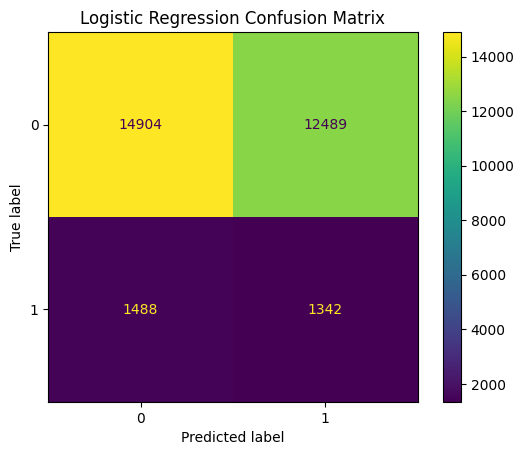

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [45]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_resampled, y_train_resampled)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [46]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

auc_pr_rf = average_precision_score(y_test, y_prob_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest Results")
print("AUC-PR:", auc_pr_rf)
print("F1-Score:", f1_rf)


Random Forest Results
AUC-PR: 0.14515315546436985
F1-Score: 0.1843502023227705


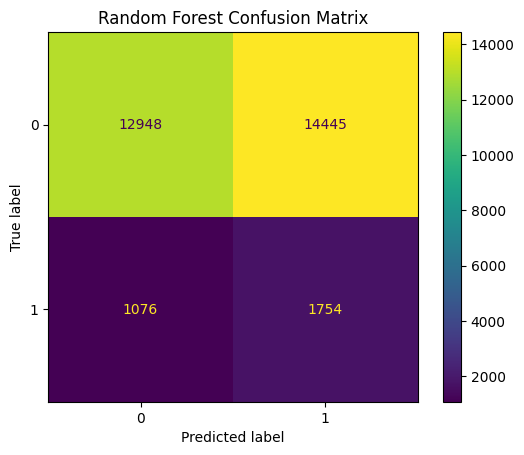

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title("Random Forest Confusion Matrix")
plt.show()


In [48]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc_pr = cross_val_score(
    rf,
    X_train_resampled,
    y_train_resampled,
    cv=skf,
    scoring='average_precision'
)

print("Cross-Validation AUC-PR Scores:", cv_auc_pr)
print("Mean AUC-PR:", cv_auc_pr.mean())
print("Std Dev:", cv_auc_pr.std())


Cross-Validation AUC-PR Scores: [0.66374131 0.66200207 0.66102588 0.65380177 0.66707678]
Mean AUC-PR: 0.661529562131066
Std Dev: 0.00437856555334472


In [49]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "AUC-PR": [auc_pr_lr, auc_pr_rf],
    "F1-Score": [f1_lr, f1_rf]
})

comparison


,Model,AUC-PR,F1-Score
0,Logistic Regression,0.095263,0.161095
1,Random Forest,0.145153,0.184350


### Model Selection

Random Forest outperformed Logistic Regression in both AUC-PR and F1-score, indicating better detection of fraudulent transactions in this highly imbalanced dataset. While Logistic Regression offers higher interpretability, Random Forest captures complex non-linear patterns more effectively. Therefore, Random Forest is selected as the final model, with explainability addressed using SHAP in Task 3.


In [50]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "AUC-PR": [auc_pr_lr, auc_pr_rf],
    "F1-Score": [f1_lr, f1_rf]
})

comparison


,Model,AUC-PR,F1-Score
0,Logistic Regression,0.095263,0.161095
1,Random Forest,0.145153,0.184350


## Task 2 – Model Selection and Justification

In this task, two classification models were developed and evaluated for fraud detection: Logistic Regression as an interpretable baseline and Random Forest as an ensemble model. Evaluation was conducted using AUC-PR, F1-score, and confusion matrices, which are appropriate for highly imbalanced datasets.

The Random Forest model achieved higher AUC-PR and F1-score compared to Logistic Regression, demonstrating stronger capability in identifying fraudulent transactions while maintaining acceptable false positive rates. Although Logistic Regression offers simplicity and interpretability, it was less effective at capturing the complex, non-linear relationships present in the data.

Therefore, Random Forest was selected as the final model for fraud detection. Model explainability and transparency will be addressed in Task 3 using SHAP.


In [51]:
import joblib

joblib.dump(rf, "../models/random_forest_fraud_model.pkl")


['../models/random_forest_fraud_model.pkl']